This notebook takes 1 March - 31 October. It uses 4 weeks of data to predict the next 2 weeks

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pandas import read_csv
import matplotlib.pyplot
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import date, timedelta
from sklearn.metrics import r2_score

In [2]:
cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
deaths  = pd.read_csv("time_series_covid19_deaths_US.csv")
density = pd.read_csv("popden.csv")

In [3]:
fips = cases[(cases['10/31/20']<10000)]
fips = fips[(fips['10/31/20']>1000)]

f = fips['FIPS'].tolist()
cases = cases[cases['FIPS'].isin(f)]
deaths = deaths[deaths['FIPS'].isin(f)]

In [4]:
cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,6024,6038,6050,6071,6079,6092,6117,6121,6143,6172
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,19136,19176,19267,19324,19361,19392,19433,19461,19554,19635
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2044,2055,2053,2057,2061,2067,2070,2074,2084,2095
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5973,5987,5997,6008,6021,6040,6042,6043,6058,6072
6,84001013,US,USA,840,1013.0,Butler,Alabama,US,31.753001,-86.680575,...,1905,1910,1924,1930,1934,1938,1940,1945,1948,1951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,84056001,US,USA,840,56001.0,Albany,Wyoming,US,41.654987,-105.723542,...,3854,3867,3871,3871,3880,3880,3887,3893,3892,3893
3317,84056005,US,USA,840,56005.0,Campbell,Wyoming,US,44.248861,-105.547440,...,4634,4639,4643,4643,4646,4646,4647,4649,4652,4655
3321,84056013,US,USA,840,56013.0,Fremont,Wyoming,US,43.041840,-108.629689,...,4683,4718,4743,4754,4764,4764,4792,4810,4816,4825
3325,84056021,US,USA,840,56021.0,Laramie,Wyoming,US,41.307025,-104.688750,...,8068,8098,8109,8116,8122,8122,8126,8135,8141,8145


In [5]:
density.drop_duplicates(subset=['fips'],keep='last',inplace=True)

strings = {'NMR','PR','VI','KSC','NYC'}
index_names = density[(density['fips']).isin(strings)].index
density.drop(index_names, inplace=True)

density['fips']=density['fips'].astype(float)

In [6]:
c = pd.merge(cases,density, left_on='FIPS',right_on='fips')
d = pd.merge(deaths,density, left_on='FIPS',right_on='fips')

In [7]:
col = {'UID','iso2','iso3','code3','FIPS','Admin2','Province_State','Country_Region','Lat','Long_','Combined_Key','date','county','state','fips','cases','deaths','stay_at_home_announced','stay_at_home_effective','lat','lon','total_population','area_sqmi'}
c.drop(c.columns[c.columns.isin(col)],axis=1,inplace=True)
d.drop(d.columns[d.columns.isin(col)],axis=1,inplace=True)

In [8]:
from sklearn.preprocessing import minmax_scale
d['population_density_per_sqmi']=minmax_scale(d['population_density_per_sqmi'])
c['population_density_per_sqmi']=minmax_scale(c['population_density_per_sqmi'])

In [9]:
c

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,population_density_per_sqmi
0,0,0,0,0,0,0,0,0,0,0,...,6038,6050,6071,6079,6092,6117,6121,6143,6172,0.008940
1,0,0,0,0,0,0,0,0,0,0,...,19176,19267,19324,19361,19392,19433,19461,19554,19635,0.012209
2,0,0,0,0,0,0,0,0,0,0,...,2055,2053,2057,2061,2067,2070,2074,2084,2095,0.002726
3,0,0,0,0,0,0,0,0,0,0,...,5987,5997,6008,6021,6040,6042,6043,6058,6072,0.008631
4,0,0,0,0,0,0,0,0,0,0,...,1910,1924,1930,1934,1938,1940,1945,1948,1951,0.002332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0,0,0,0,0,0,0,0,0,0,...,3867,3871,3871,3880,3880,3887,3893,3892,3893,0.000617
1033,0,0,0,0,0,0,0,0,0,0,...,4639,4643,4643,4646,4646,4647,4649,4652,4655,0.000740
1034,0,0,0,0,0,0,0,0,0,0,...,4718,4743,4754,4764,4764,4792,4810,4816,4825,0.000177
1035,0,0,0,0,0,0,0,0,0,0,...,8098,8109,8116,8122,8122,8126,8135,8141,8145,0.003306


In [10]:
cases.fillna(0,inplace=True)
deaths.fillna(0,inplace=True)

deaths_results_MAE = np.zeros(15)
cases_results_MAE = np.zeros(15)

deaths_results_RMSE = np.zeros(15)
cases_results_RMSE = np.zeros(15)

deaths_score = np.zeros(15)
cases_score = np.zeros(15)

In [11]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {'population_density_per_sqmi'}
    for i in range(0,28):
        s = x_date + timedelta(days=i)
        #print(s)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        #print(s)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    x = deaths.filter(x_days)
    y = deaths.filter(y_days)
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    deaths_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    deaths_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int),squared='False')
    deaths_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

In [12]:
deaths_results_MAE

array([0.94346649, 1.62356127, 1.5169262 , 1.60765064, 1.31956669,
       1.36086662, 1.07989167, 1.39167231, 1.85308057, 1.6858497 ,
       2.01861882, 1.85477319, 2.05585647, 2.08970887, 2.21563981])

In [13]:
deaths_results_RMSE

array([ 7.86425186, 15.11306703, 13.56093433, 12.58192282,  8.11238998,
       12.14488829,  5.99052133,  8.84258632, 11.16181449,  8.22207177,
       11.96648612, 10.04570074, 12.31245768, 15.03215978, 12.72071767])

In [14]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {'population_density_per_sqmi'}
    for i in range(0,28):
        s = x_date + timedelta(days=i)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    x = cases.filter(x_days)
    y = cases.filter(y_days)
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    cases_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    cases_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int),squared='False')
    cases_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

In [15]:
cases_results_MAE

array([16.62897766, 22.85985105, 25.95463778, 23.92044685, 28.1831415 ,
       28.32125931, 39.08429248, 40.50643196, 54.63744076, 47.53351388,
       48.62999323, 57.01150982, 61.647935  , 66.59851049, 72.04976303])

In [43]:
X_train

,9/22/20,10/6/20,9/23/20,9/14/20,9/15/20,10/8/20,9/27/20,9/13/20,9/21/20,10/3/20,...,9/16/20,9/17/20,9/30/20,9/18/20,9/29/20,10/1/20,10/4/20,10/5/20,10/10/20,9/28/20
942,1011,1191,1011,858,858,1223,1070,858,978,1131,...,858,858,1098,951,1098,1128,1163,1163,1223,1070
2366,1959,2181,1971,1838,1857,2245,2037,1824,1945,2112,...,1890,1900,2078,1909,2057,2091,2150,2164,2325,2049
1376,1365,1509,1375,1274,1280,1545,1429,1257,1360,1479,...,1284,1303,1451,1319,1446,1459,1494,1500,1570,1437
1162,7773,7954,7794,7632,7632,8005,7856,7623,7745,7907,...,7645,7698,7892,7708,7869,7899,7947,7947,8028,7854
1193,4122,4348,4140,4018,4017,4382,4214,4010,4097,4302,...,4038,4053,4259,4067,4238,4277,4334,4339,4396,4223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,667,851,697,588,588,864,733,567,667,786,...,588,588,781,637,757,781,810,851,882,757
1472,5448,5947,5477,5173,5224,6019,5623,5154,5425,5789,...,5276,5321,5694,5354,5678,5724,5811,5825,6123,5650
349,4862,5329,4895,4593,4607,5383,5077,4578,4831,5252,...,4629,4672,5151,4723,5127,5193,5285,5304,5407,5091
3307,2484,2780,2503,2116,2239,2825,2584,2093,2458,2728,...,2282,2332,2629,2374,2618,2645,2749,2760,2885,2584


In [16]:
cases_results_RMSE

array([ 2962.35680433,  3252.28842248,  4667.61746784,  3093.56499661,
        4875.07616791,  4954.48849018,  7202.9746107 ,  6798.47122546,
        9536.91299932,  5668.90589032,  9750.36932972, 14241.78808395,
       10249.61475965, 10944.51117129, 13080.10798917])

In [17]:
cases_score

array([0.82734392, 0.95110894, 0.97188952, 0.98940129, 0.98826683,
       0.99013768, 0.98867348, 0.99259078, 0.99267904, 0.99662815,
       0.99535077, 0.99409433, 0.99630293, 0.99652615, 0.99656773])

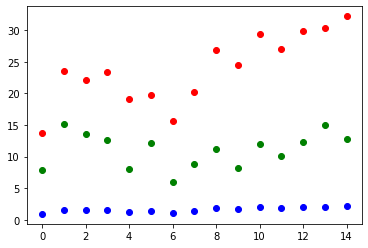

In [48]:
x_axis = np.arange(0,15)
plt.plot(x_axis,deaths_results_MAE,'bo')
plt.plot(x_axis,deaths_results_RMSE,'go')
plt.plot(x_axis,deaths_results_MAE*math.sqrt(len(X_test)),'ro')

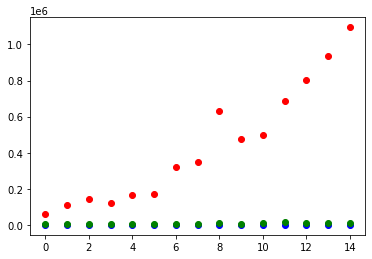

In [52]:
import math
plt.plot(x_axis,cases_results_MAE,'bo')
plt.plot(x_axis,cases_results_RMSE,'go')
plt.plot(x_axis,cases_results_MAE*cases_results_MAE*(len(X_test)),'ro')

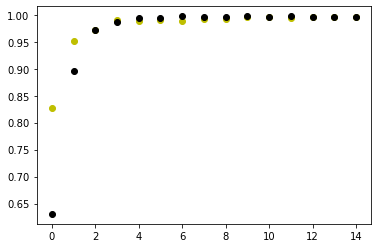

In [20]:
plt.plot(x_axis,cases_score,'yo')
plt.plot(x_axis,deaths_score,'ko')

In [34]:
MAE_1 = cases_results_RMSE
MAE_2 = np.asarray([ 2931.25795531,  3258.18280298,  5816.00236967,  2927.0450237 ,
        4257.64285714,  5950.58700068,  5352.08192282,  7969.53588355,
        9580.13405552,  4063.75964794, 10660.49932295, 16895.25253893,
       13886.46953284,  7512.39065674, 13653.93398781])

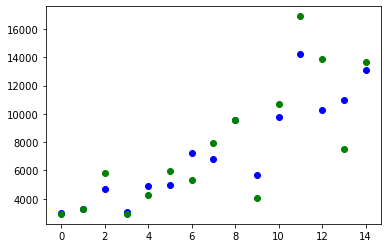

In [35]:
plt.plot(x_axis,MAE_1,'bo')
plt.plot(x_axis,MAE_2,'go')

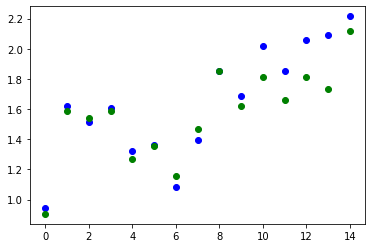

In [37]:
MAE_3 = deaths_results_MAE
MAE_4 = np.asarray([0.90453622, 1.5859851 , 1.53859174, 1.58903182, 1.27014218,
       1.352065  , 1.1563981 , 1.46682464, 1.84969533, 1.62085308,
       1.80974949, 1.66316858, 1.81279621, 1.73493568, 2.11814489])
plt.plot(x_axis,MAE_3,'bo')
plt.plot(x_axis,MAE_4,'go')

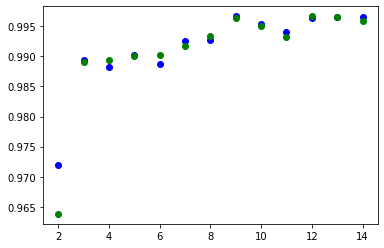

In [24]:
#Density
c_score1 = cases_score
#No Density
c_score2 = np.asarray([0.8300102 , 0.95180465, 0.96384375, 0.9891135 , 0.98935309,
       0.99008621, 0.99027089, 0.99169037, 0.99338813, 0.99638814,
       0.99495131, 0.99325977, 0.9965981 , 0.99643575, 0.99591209])
plt.plot(x_axis[2:],c_score1[2:],'bo')
plt.plot(x_axis[2:],c_score2[2:],'go')

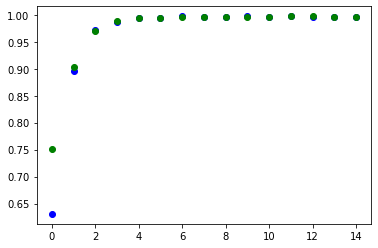

In [25]:
d_score1 = deaths_score
d_score2 = np.asarray([0.75144915, 0.90268227, 0.96945327, 0.98799914, 0.99350377,
       0.99403161, 0.99605661, 0.99538556, 0.99520582, 0.99593972,
       0.99662951, 0.9972659 , 0.99719205, 0.9966172 , 0.99640705])
plt.plot(x_axis,d_score1,'bo')
plt.plot(x_axis,d_score2,'go')

In [26]:
cases_score

array([0.82734392, 0.95110894, 0.97188952, 0.98940129, 0.98826683,
       0.99013768, 0.98867348, 0.99259078, 0.99267904, 0.99662815,
       0.99535077, 0.99409433, 0.99630293, 0.99652615, 0.99656773])

In [27]:
deaths_score

array([0.63072141, 0.89583901, 0.97185666, 0.98670067, 0.99399675,
       0.99317531, 0.99727043, 0.99654505, 0.99580878, 0.99680579,
       0.99620871, 0.99712186, 0.99664161, 0.99608622, 0.99644837])

In [28]:
cerr = c_score1-c_score2

In [29]:
derr = d_score1-d_score2

In [30]:
cerr.sum()

0.0044555833777417675

In [31]:
derr.sum()

-0.12459199464978143